<a href="https://colab.research.google.com/github/EJMpanduki/ComputerVisionTwistChallenge/blob/main/Emunael_Mpanduki_Twist_Challenge_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Import All the necessary packages to solve problem

In [3]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision.datasets import ImageFolder
import os
import scipy
from scipy import stats
import pandas as pd
from PIL import Image, ImageFilter
import tensorflow as tf

Set up classification algorithm

Define the model


In [5]:
#For our model, we need the number of classes (5) and shape of the images
num_classes = 5
input_shape = (192, 192, 3)


5 (192, 192, 3)


In [6]:
# This is simply an alias for convenience
layers = tf.keras.layers

'''INPUT:
      num_classes = len(np.unique(target)) (number of classes in the target)
      input_shape = x_train.shape[1:] (the shape of our dataset excluding the first dimension corresponding to the number of images)
  OUTPUT: 
      the model
  CALL: 
      model = build_pretrained_vgg_model(num_classes, input_shape) 
      model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.005), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) '''

def build_pretrained_vgg_model(num_classes, input_shape): 
  """Constructs a CNN with a VGG16's convolutional base and two fully-connected hidden layers on top. The convolutional base is frozen (the weights can't be updated) and has weights from training on the ImageNet dataset.
  Returns:
    The model.
  """
  # This loads the VGG16 model from TensorFlow with ImageNet weights
  vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
 
  # First we flatten out the features from the VGG16 model
  net = layers.Flatten()(vgg_model.output)
 
  # We create a new fully-connected layer that takes the flattened features as its input
  net = layers.Dense(512, activation=tf.nn.relu)(net)
  # And we add one more hidden layer
  net = layers.Dense(512, activation=tf.nn.relu)(net)
 
  # Then we add a final layer which is connected to the previous layer and
  # groups our images into one of the five classes
  output = layers.Dense(num_classes, activation=tf.nn.softmax)(net)
 
  # Finally, we create a new model whose input is that of the VGG16 model and whose output
  # is the final new layer we just created
  model = tf.keras.Model(inputs=vgg_model.input, outputs=output)
 
  # We loop through all layers except the last four and specify that we do not want 
  # their weights to be updated during training. The weights of the convolutional
  # layers have already been trained for general-purpose feature extraction, and we only
  # want to update the fully-connected layers that we just added.
  for layer in model.layers[:-4]:
      layer.trainable = False
 
  return model

#We define our model with the above function
model = build_pretrained_vgg_model(num_classes, input_shape) 

#We compile our model. It is now ready for training. A learning rate of 0.005 was also tested, yielding every time worse results.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


In [7]:
# This is the directory where model weights are saved. 
CHECKPOINT_DIR = '/content/drive/My Drive/Colab Notebooks/Module 2/'


In [8]:
#We choose the epoch when the validation loss is lowest and accuracy highest
EARLY_STOPPING_EPOCH = 3

assert EARLY_STOPPING_EPOCH > 0, 'Set an early stopping point!'

# Path the the checkpoint we want to load
es_ckpt_path = os.path.join(CHECKPOINT_DIR, 'Newweights.epoch.{:02d}'.format(EARLY_STOPPING_EPOCH))

#We define our model with the above function
model = build_pretrained_vgg_model(num_classes, input_shape)

# Then we load the weights from the desired checkpoint into the model
model.load_weights(es_ckpt_path);

This script will show you how to read frames from a video, resize it and sample sub-images

In [9]:
def sample_image(img, x, y, win_size, cnn_size):
  h, w, = img.shape

  delta = int(win_size/2)

  x0 = x - delta 
  x1 = x + delta
  y0 = y - delta
  y1 = y + delta

  if y0 < 0:
      y0 = int(0)
      y1 = int(win_size * 2)
  
  if y1 > h:
      y0 = int(h - win_size * 2)
      y1 = int(h)
  
  if x0 < 0:
      x0 = int(0)
      x1 = int(win_size * 2)
  
  if x1 > w:
      x0 = int(w - win_size * 2)
      x1 = int(w)

  img_sample = img[y0:y1, x0:x1]

  #Creating the empty array where the data will be stored
  all_im = np.empty((0,192,192,3))
  
  #Creating the empty array where the prediction output will be stored
  pred = np.empty((0))

  # convert to CNN format
  #resize
  img_resize = cv2.resize(img_sample, (cnn_size, cnn_size), interpolation=cv2.INTER_LINEAR)

  # NORMALIZING
  img_norm_res = (img_resize - 127.5) / 127.5

  #ADAPT SHAPE

  if img_norm_res.ndim == 3:
    #Verify if all three channels are the same
    chan_1 = img_norm_res[:,:,0]
    chan_2 = img_norm_res[:,:,1]
    chan_3 = img_norm_res[:,:,2]

    diff = chan_1 - chan_2
    diff1 = chan_2 - chan_3

    assert np.nonzero(diff) != None, 'Channels have different values'
    assert np.nonzero(diff1) != None, 'Channels have different values'

    img_norm_res_3D = img_norm_res

  elif img_norm_res.ndim == 2:
    #In the expanded dataset, the images only have 2 dimensions

    # ADD A CHANNEL DIMENSION
    img_norm_res_3D = np.expand_dims(img_norm_res, axis=2)

    #Some models require that its input image have three channels
    #ADD TWO MORE CHANNELS WITH THE SAME VALUES AS THE FIRST
    img_norm_res_3D = np.repeat(img_norm_res_3D, 3, axis=2)

  #ADD IMAGE TO ARRAY
  all_im = np.concatenate((all_im,img_norm_res_3D[np.newaxis,:,:,:]),axis=0)

  pred = np.append(pred, 'Sample')

  return all_im, pred


Making Predictions

In [53]:

#declare the video path
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_1.mp4"

#path to export images
export_path = "/content/drive/My Drive/Colab Notebooks/Module 2/"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

sample_window_size = 150
cnn_img_size = 192
composition_df = pd.DataFrame( columns = ['chip', 'pellet', 'fine','lump','mixed'])

tic = time.process_time()

#creating frame samples because full sample will take too long
start_frame = 0 
end_frame = 150

# for frame_num in range(1"""N_frames"""):
for frame_num in range(end_frame):
    if frame_num < start_frame: #pass and go to next frame
        pass
    else:
      has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

      if has_img:
          # Images in your trainging set were monochrome
          img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

          # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.

          #create a sample array (center, top left, top right, bottom left, bottom right)
          x_array = [300, 175, 400, 425, 150]
          y_array = [240, 175, 175, 300, 325]
          sample_array = np.empty((0,192,192,3))
          for i in range(len(x_array)):
            sample, rect = sample_image(img_mono, int(x_array[i]), int(y_array[i]), sample_window_size, cnn_img_size)
            sample_array = np.concatenate((sample_array,sample),axis=0)
  #         cv2.imshow('test',sample) 
  #         cv2.waitKey(100)

          # TODO: CLASSIFER CODE HERE
          preds =  model.predict(sample_array)
          composition = np.mean(preds, axis = 0)*100
          X = np.reshape(composition,(1, composition.size))
          composition_df =composition_df.append(pd.DataFrame(X, columns= composition_df.columns), ignore_index=True)
          # TODO: DECIDE IF NOFITICATION FRAME SHOUD BE SAVED

      frames_to_export = [24, 102, 138]
      if frame_num in frames_to_export:
        cv2.imwrite(export_path + 'bin_1_frame_num_' + str(frame_num) +".jpeg", img_mono)




          # TODO: BUILD ARRAY FOR MATERIAL COMPOSITION GRAPH

          # COLAB
          # - - - - - - - - - - - - 
          # clear_output(wait=True)
          # cv2_imshow(sample) 
          # cv2.waitKey(1000) & 0xff
          # # - - - - - - - - - - - - 

          # Local
          # - - - - - - - - - - - - 
          # cv2.imshow('test',img_mono) 
          # cv2.waitKey(1000)
  #         cv2.destroyAllWindows()
          # - - - - - - - - - - - -  



In [57]:
dt = time.process_time() - tic
print(dt/end_frame) # Samples per frame should be below 150 ms

3.6641620172999985


In [55]:
composition_df

,chip,pellet,fine,lump,mixed
0,0.000019,62.398994,36.051960,0.000249,1.548765
1,0.000017,67.543755,30.955734,0.000208,1.500296
2,0.000019,68.654381,29.974953,0.000209,1.370440
3,0.000017,59.773212,39.841476,0.000146,0.385146
4,0.000016,60.063507,39.521534,0.000147,0.414795
...,...,...,...,...,...
145,0.000006,42.612247,57.194771,0.000289,0.192689
146,0.000008,43.660259,56.105839,0.000326,0.233566
147,0.000008,43.795578,55.992039,0.000328,0.212050
148,0.000008,43.827938,55.928940,0.000326,0.242785


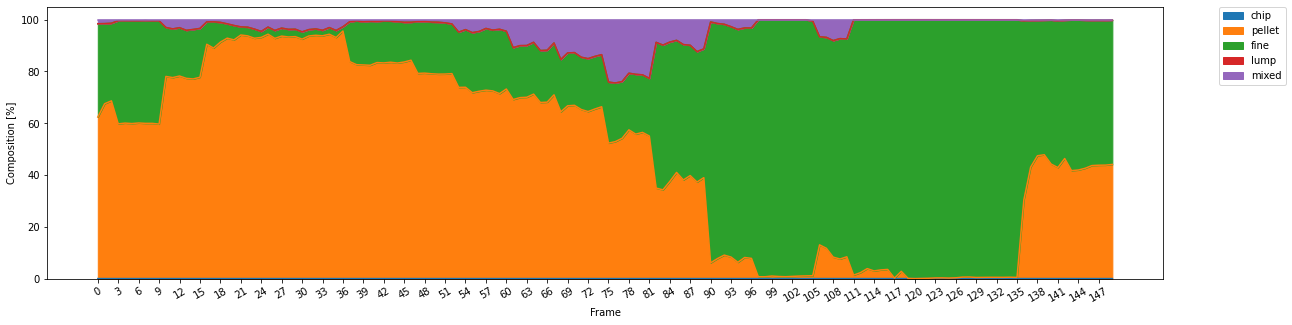

In [56]:
#Create Plots and Export

xticks = list(range(start_frame,end_frame,3))
def plot_bin_composition(pred_df):
  ax = pred_df.plot.area( figsize=(20, 5), xticks=xticks)
  ax.set_xlabel("Frame")
  ax.set_ylabel("Composition [%]")
  ax.set_xticklabels(xticks, rotation=30)
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plot_bin_composition(composition_df)


plt.savefig(f"{export_path}/bin_1_composition.png")